# U-Net

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [2]:
import torch
from unet import UNet

In [3]:
import pysteps

Pysteps configuration file found at: /home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/pysteps/pystepsrc



In [4]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

In [5]:
cpmdata = xr.open_mfdataset("../../../data/2.2km/rcp85/01/pr/*.nc").rename({"pr": "target_pr"})
cpmdata = cpmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))]
cpmdata = cpmdata.reset_coords()[['target_pr']]
cpmdata

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 720)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [6]:
regridded_gcmdata = xr.open_mfdataset('../../../derived_data/60km/rcp85/01/*/day/*.nc')
regridded_gcmdata = regridded_gcmdata.loc[dict(ensemble_member=1, time=slice("1980-12-01","1982-11-30"))]
regridded_gcmdata = regridded_gcmdata.reset_coords()[['pr', 'psl']]
regridded_gcmdata

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 720)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(720, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(720, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [7]:
merged_data = xr.merge([regridded_gcmdata, cpmdata])
# select a small subset of the data for trial purposes
# merged_data = merged_data.isel({"grid_latitude": slice(512), "grid_longitude": slice(512)})

# split training/test based on date
training_data = merged_data.sel({"time": slice("1980-12-01", "1981-11-30")})
validation_data = merged_data.sel({"time": slice("1981-12-01", "1982-05-30")})
test_data = merged_data.sel({"time": slice("1982-06-01", "1982-11-30")})

In [8]:
training_data

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 360)
Coordinates:
  * time            (time) object 1980-12-01 12:00:00 ... 1981-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [9]:
validation_data

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 180)
Coordinates:
  * time            (time) object 1981-12-01 12:00:00 ... 1982-05-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [10]:
test_data

<xarray.Dataset>
Dimensions:         (grid_latitude: 606, grid_longitude: 484, time: 180)
Coordinates:
  * time            (time) object 1982-06-01 12:00:00 ... 1982-11-30 12:00:00
  * grid_latitude   (grid_latitude) float64 -4.683 -4.647 -4.611 ... 8.027 8.063
  * grid_longitude  (grid_longitude) float64 353.9 354.0 354.0 ... 364.3 364.3
Data variables:
    pr              (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    psl             (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
    target_pr       (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(180, 606, 484), meta=np.ndarray>
Attributes: (12/18)
    collection:      land-gcm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2018-11-03T10:11:47
    description:     Precipitation rate
    domain:          uk
    frequency:       day
    ...              ...
    resolution:      60km
    scenario:        rcp85
    source:          UKCP18 global realisation from a set of 15 perturbed var...
    title:           UKCP18 land projections - 60km global climate model, pre...
    version:         v20181122
    Conventions:     CF-1.7

In [11]:
model = UNet(2, 1)
model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [12]:
box_size = 16
batch_size = 4
epochs = 10

bl_long_idx = 250
bl_lat_idx = 150

latlong_ibox = {"grid_latitude": slice(bl_lat_idx, bl_lat_idx+box_size), "grid_longitude": slice(bl_long_idx, bl_long_idx+box_size)}

In [13]:
batch = training_data.isel(latlong_ibox).isel({"time": slice(batch_size)})
training_tensor = torch.stack((torch.from_numpy(batch.psl.values),  torch.from_numpy(batch.pr.values)), dim=1)
output = model(training_tensor)
labels = torch.from_numpy(batch.target_pr.values)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [14]:
model = UNet(2, 1)

In [15]:
criterion = torch.nn.L1Loss(reduction='mean')

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

In [17]:
for epoch in range(epochs):
    model.train()
    
    epoch_loss = 0
    for i in range(len(training_data.time)//batch_size):
        training_batch = training_data.isel(latlong_ibox).isel({"time": slice(i*batch_size, (i+1)*batch_size)})

        training_batch_inputs_tensor = torch.stack((torch.from_numpy(training_batch.psl.values),  torch.from_numpy(training_batch.pr.values)), dim=1)
        training_batch_labels_tensor = torch.from_numpy(training_batch.target_pr.values)
        
        # Compute prediction and loss
        training_batch_outputs_tensor = model(training_batch_inputs_tensor)
        loss = criterion(training_batch_outputs_tensor.squeeze(), training_batch_labels_tensor)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Progress
        epoch_loss += loss.item()
        if (i+1) % 30 == 0:
            print(f"Epoch {epoch}: Batch {i} Loss {loss.item()}")
    
    model.eval()

    epoch_val_loss = 0
    for i in range(len(validation_data.time)//batch_size):
        with torch.no_grad():
            val_batch = validation_data.isel(latlong_ibox).isel({"time": slice(i*batch_size, (i+1)*batch_size)})

            val_batch_inputs_tensor = torch.stack((torch.from_numpy(val_batch.psl.values),  torch.from_numpy(val_batch.pr.values)), dim=1)
            val_batch_labels_tensor = torch.from_numpy(val_batch.target_pr.values)

            # Compute prediction and loss
            val_batch_outputs_tensor = model(val_batch_inputs_tensor)
            val_loss = criterion(val_batch_outputs_tensor.squeeze(), val_batch_labels_tensor)
        
        
        # Progress
        epoch_val_loss += val_loss.item()

    print(f"Epoch {epoch}: Loss {epoch_loss} Val loss {epoch_val_loss}")
        
    model.train()

Epoch 0: Batch 29 Loss 2.2278475761413574
Epoch 0: Batch 59 Loss 0.5372752547264099
Epoch 0: Batch 89 Loss 3.1942124366760254
Epoch 0: Loss 289.06523180007935 Val loss 165.68264465779066
Epoch 1: Batch 29 Loss 2.1052439212799072
Epoch 1: Batch 59 Loss 0.6233044862747192
Epoch 1: Batch 89 Loss 3.2172603607177734
Epoch 1: Loss 288.0223700106144 Val loss 162.9726563617587
Epoch 2: Batch 29 Loss 2.0715105533599854
Epoch 2: Batch 59 Loss 0.6243981719017029
Epoch 2: Batch 89 Loss 3.268125057220459
Epoch 2: Loss 288.2726515829563 Val loss 162.73186865448952
Epoch 3: Batch 29 Loss 2.0886306762695312
Epoch 3: Batch 59 Loss 0.6797108054161072
Epoch 3: Batch 89 Loss 3.2334134578704834
Epoch 3: Loss 287.85443779826164 Val loss 162.7536066994071
Epoch 4: Batch 29 Loss 2.025521993637085
Epoch 4: Batch 59 Loss 0.7310726642608643
Epoch 4: Batch 89 Loss 3.0790762901306152
Epoch 4: Loss 286.3507066965103 Val loss 160.56449426710606
Epoch 5: Batch 29 Loss 1.9796631336212158
Epoch 5: Batch 59 Loss 0.74934

In [18]:
model.eval()
with torch.no_grad():
    test_batch = test_data.isel(latlong_ibox).isel({"time": slice(0*batch_size, (0+1)*batch_size)})
    test_batch_inputs_tensor = torch.stack((torch.from_numpy(test_batch.psl.values),  torch.from_numpy(test_batch.pr.values)), dim=1)
    test_batch_outputs_tensor = model(test_batch_inputs_tensor)
model.train()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

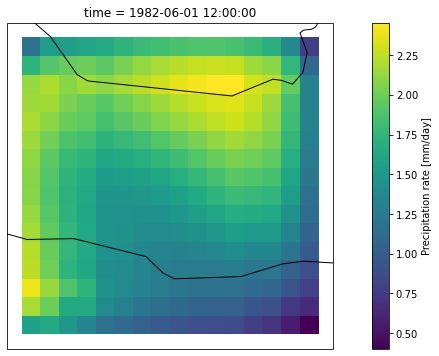

In [19]:
test_data['pred_pr'] = xr.full_like(test_data.target_pr, fill_value=0)
# test_data['new_var'] = xr.where(pr_single_day['new_var'].coords["grid_latitude"] < 0, 100, pr_single_day["new_var"])
test_data['pred_pr'][{**latlong_ibox, "time": slice(0*batch_size, (0+1)*batch_size)}] = test_batch_outputs_tensor.squeeze().numpy()

plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

# xplt.plot(test_data['pred_pr'][{"grid_latitude": slice(box_size*12), "grid_longitude": slice(box_size*12)}][{"time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)
xplt.plot(test_data['pred_pr'][{**latlong_ibox, "time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

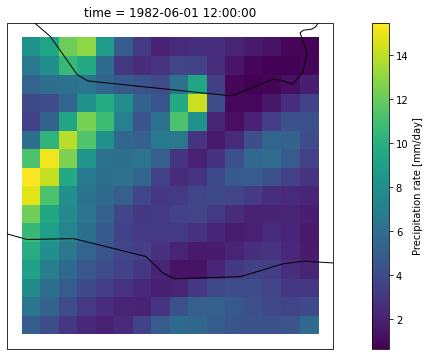

In [20]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(test_data['target_pr'][{**latlong_ibox, "time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)

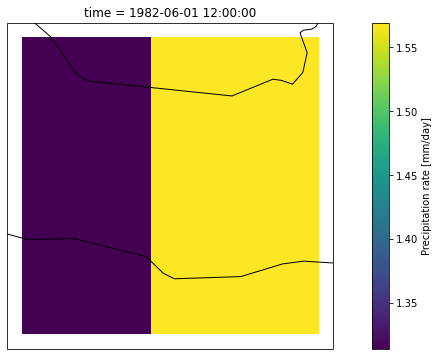

In [21]:
plt.figure(figsize=(14,6))

ax = plt.axes(projection=cp_model_rotated_pole)
ax.coastlines()

xplt.plot(test_data['pr'][{**latlong_ibox, "time": 0}], x='grid_longitude', y='grid_latitude', add_colorbar=True, transform=cp_model_rotated_pole)